# Preprocessing Input

In [1]:
import numpy as np
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from skimage.util import random_noise
from scipy.stats import norm
import cv2
np.random.seed(42)

In [2]:
# INPUT folder (make sure all dataset are stored in this path)
FILE_PATH = 'JPEGImages/'

# INPUT folder (lower resolution and square dimension)
IN_PATH = 'DATAImages/'

# OUTPUT folder 
OUT_PATH = 'NOISEImages/' 

# INPUT Dimension
SIZE = (256, 256)

def lower_resolution(PATH=FILE_PATH, OUT=IN_PATH, size = SIZE):
    ''' Lower resolution and Square Dimension '''
    # Create output directory, overwrite if exists
    shutil.rmtree(OUT, ignore_errors=True)
    os.makedirs(OUT)

    for i in os.listdir(PATH):
        # transform color to greyscale
        res_img = Image.open(os.path.join(PATH, i)).convert('L')
        res_img = np.array(res_img.resize(size, Image.ANTIALIAS))

        cv2.imwrite(os.path.join(OUT,i), res_img)

def noise_addition(PATH=IN_PATH, OUT=OUT_PATH, mode="gauss", grey = False, prob = 0.2):
    ''' Add noise to the dataset and store in a directory'''
    # Create output directory, overwrite if exists
    shutil.rmtree(OUT, ignore_errors=True)
    os.makedirs(OUT)
    
    for i in os.listdir(PATH):
        # Load the image
        if grey:
            img = cv2.imread(os.path.join(PATH,i), cv2.IMREAD_GRAYSCALE) 
        else:
            img = cv2.imread(os.path.join(PATH,i))
        
        out_img = 0
    
        if mode == "sp":
            # Add salt-and-pepper noise
            noise = random_noise(img, mode='s&p',amount=prob)
            out_img = np.array(255 * noise, dtype = 'uint8')
        elif mode == "gauss":
            # Add Gaussian noise
            gauss = np.random.normal(0,1,img.size)
            gauss = gauss.reshape(img.shape[0],img.shape[1])
            out_img = img + 10 * gauss
        cv2.imwrite(os.path.join(OUT,i), out_img)

lower_resolution()
noise_addition(grey=True, mode="sp", prob=0.01)


# Total Variation with GrayScale

(256, 256)
(256, 256)


(-0.5, 255.5, 255.5, -0.5)

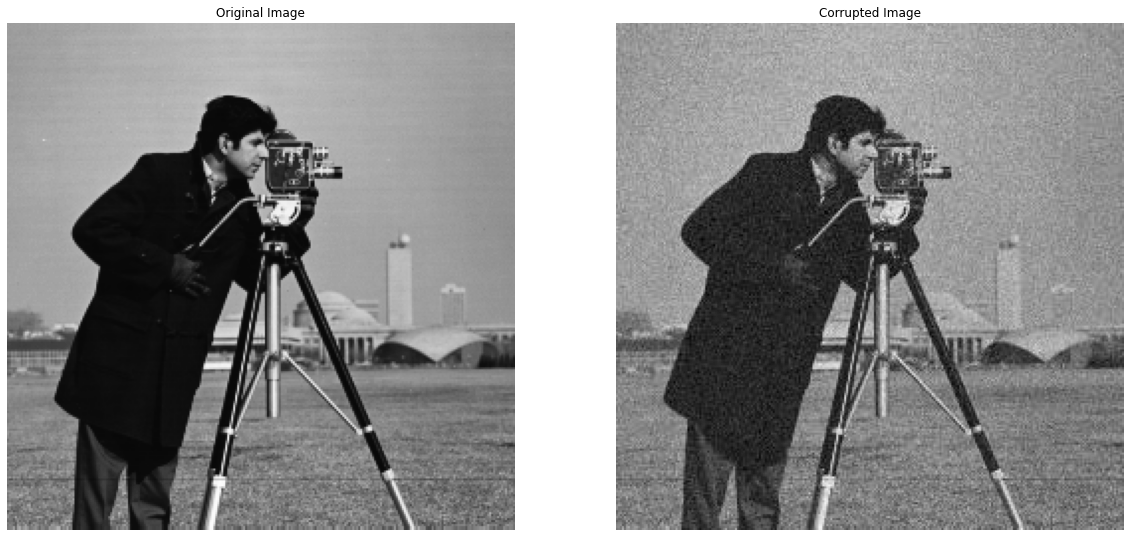

In [154]:
# Load the images.
orig_img = Image.open("cameraman.tif").convert('L')
corr_img = Image.open("cameramanNoise.jpg")
print(orig_img.size)
print(corr_img.size)

# Convert to arrays.
Uorig = np.array(orig_img)
Ucorr = np.array(corr_img)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(orig_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')

In [3]:
def denoise(img, lam=1):
    ''' OBJ = Fidelity term + Lambda * Total variation of gradient '''
    ''' Constraint: '''
    var = cp.Variable(img.shape)

    # fidelity term
    fid = 0.5 * cp.sum_squares(var - img)

    # regularization term
    reg = cp.tv(var)

    # objective
    obj =  cp.Minimize(fid + lam * reg)
    prob = cp.Problem(obj, constraints = [])
    prob.solve(verbose = True, solver = 'SCS')

    return var.value

In [5]:
result = denoise(Ucorr, lam=5)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 06 01:29:12 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Mar 06 01:29:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 06 01:29:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 06 01:29:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 06 01:29:12 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 06 01:29:12 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(-0.5, 255.5, 255.5, -0.5)

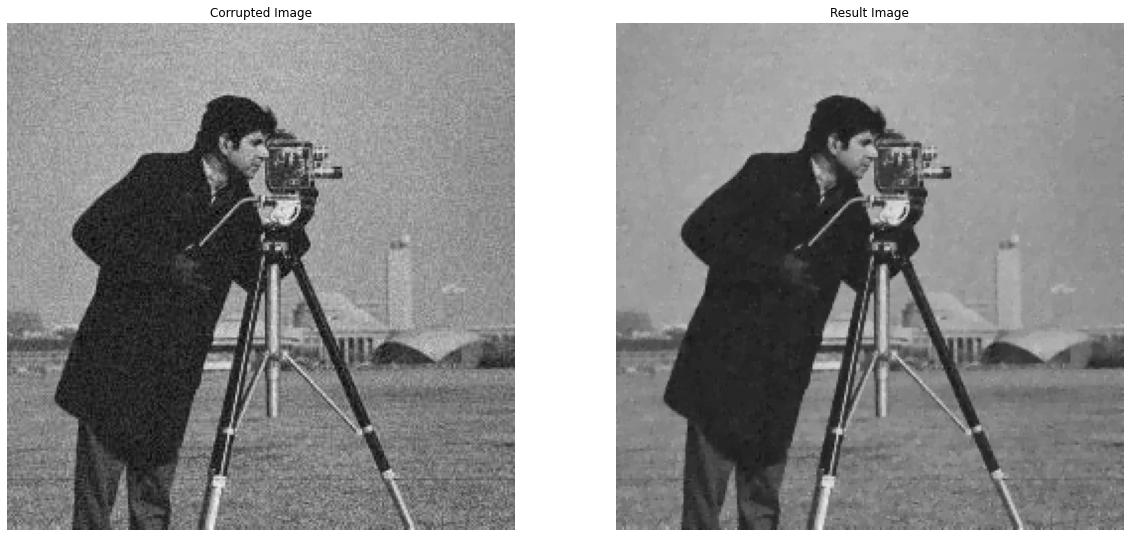

In [6]:
# Compare image.
fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(Ucorr, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Corrupted Image")
ax[0].axis('off')
ax[1].imshow(result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Result Image")
ax[1].axis('off')

# Experiment

In [8]:
lambda_list = [0.1, 0.5, 1.0, 2.0, 5.0]
result_list = []
diff_list = []

for lam in lambda_list:
    result_list.append(denoise(Ucorr, lam))
    diff_list.append(np.sum(np.abs(Uorig - result_list[-1])))

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 06 01:31:54 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Mar 06 01:31:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 06 01:31:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 06 01:31:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 06 01:31:54 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 06 01:31:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

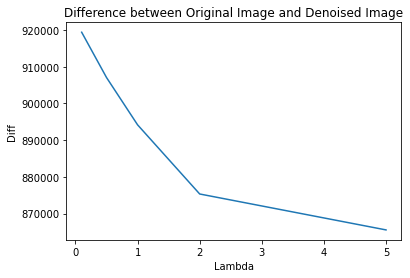

In [12]:
plt.title('Difference between Original Image and Denoised Image')
plt.xlabel('Lambda')
plt.ylabel('Diff')
plt.plot(lambda_list, diff_list)
plt.show()

(256, 256)
(256, 256)


(-0.5, 255.5, 255.5, -0.5)

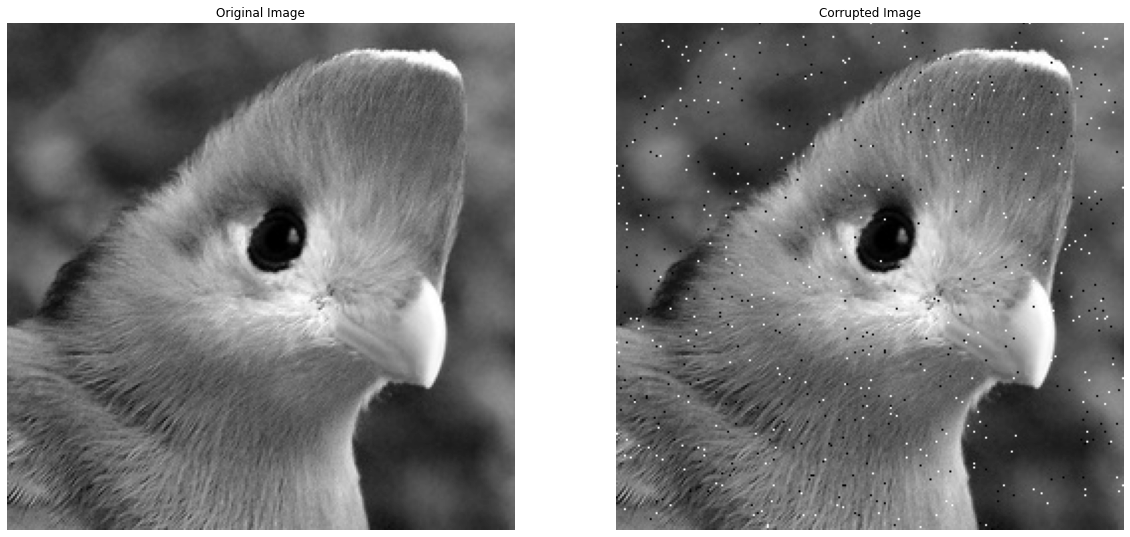

In [150]:
# Load the images.
_orig_img = Image.open("DATAImages/000064.jpg").convert('L')
_corr_img = Image.open("NOISEImages/000064.jpg")
print(_orig_img.size)
print(_corr_img.size)

# Convert to arrays.
_Uorig = np.array(_orig_img)
_Ucorr = np.array(_corr_img)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(_orig_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(_corr_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')

In [151]:
def threshold(img, thre=100):

    # known is 1 if the pixel is known,
    # 0 if the pixel was corrupted.
    known_mask = np.ones((img.shape[0], img.shape[1]))
    noise_mask = np.zeros((img.shape[0], img.shape[1]))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            diff = 0
            multi = 0
            if i != 0:
                # top
                multi += 1
                diff += abs(int(img[i][j]) - int(img[i-1][j]))

            if i != img.shape[0] - 1:
                # bottom
                multi += 1
                diff += abs(int(img[i][j]) - int(img[i+1][j]))

            if j != 0:
                # left
                multi += 1
                diff += abs(int(img[i][j]) - int(img[i][j-1]))

            if j != img.shape[1] - 1:
                # right
                multi += 1
                diff += abs(int(img[i][j]) - int(img[i][j+1]))

            if i != 0 and j != 0:
                # top-left
                multi += 1
                diff += abs(int(img[i][j]) - int(img[i-1][j-1]))

            if i != img.shape[0] - 1 and j != 0:
                # bottom-left
                multi += 1
                diff += abs(int(img[i][j]) - int(img[i+1][j-1]))
            
            if i != 0 and j != img.shape[1] - 1:
                # top-right
                multi += 1
                diff += abs(int(img[i][j]) - int(img[i-1][j+1]))

            if i != img.shape[0] - 1 and j != img.shape[1] - 1:
                # bottom-right
                multi += 1
                diff += abs(int(img[i][j]) - int(img[i+1][j+1]))
            
            
            if diff >= thre * multi:
                if img[i][j] == 255 or img[i][j] == 0:
                    known_mask[i][j] = 0
                    noise_mask[i][j] = 1

                    

    return known_mask, noise_mask


(-0.5, 255.5, 255.5, -0.5)

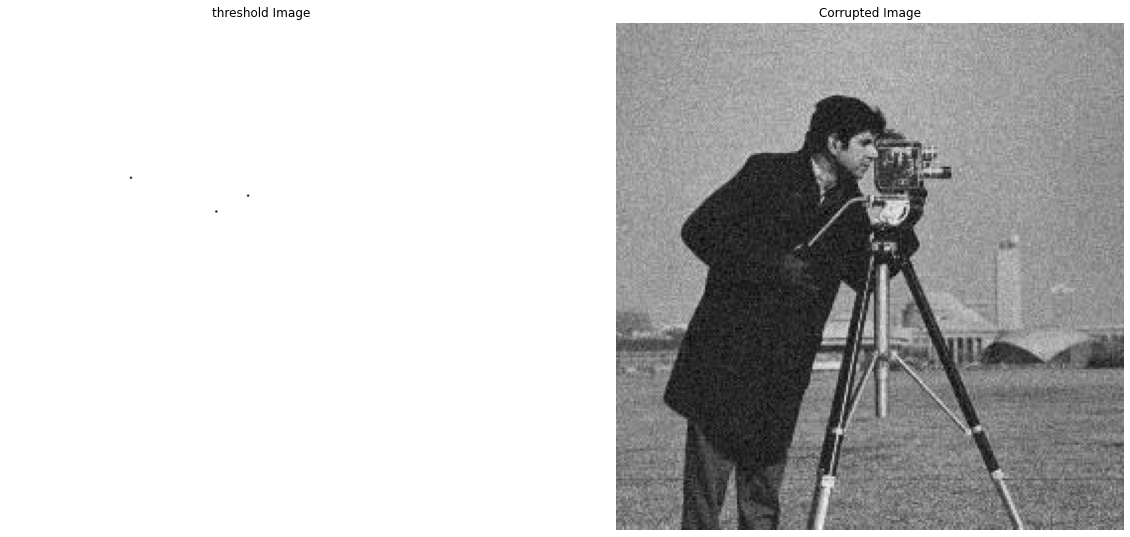

In [155]:

K, N = threshold(Ucorr, thre=30)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(K * 255, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("threshold Image")
ax[0].axis('off')
ax[1].imshow(corr_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')
            

(-0.5, 255.5, 255.5, -0.5)

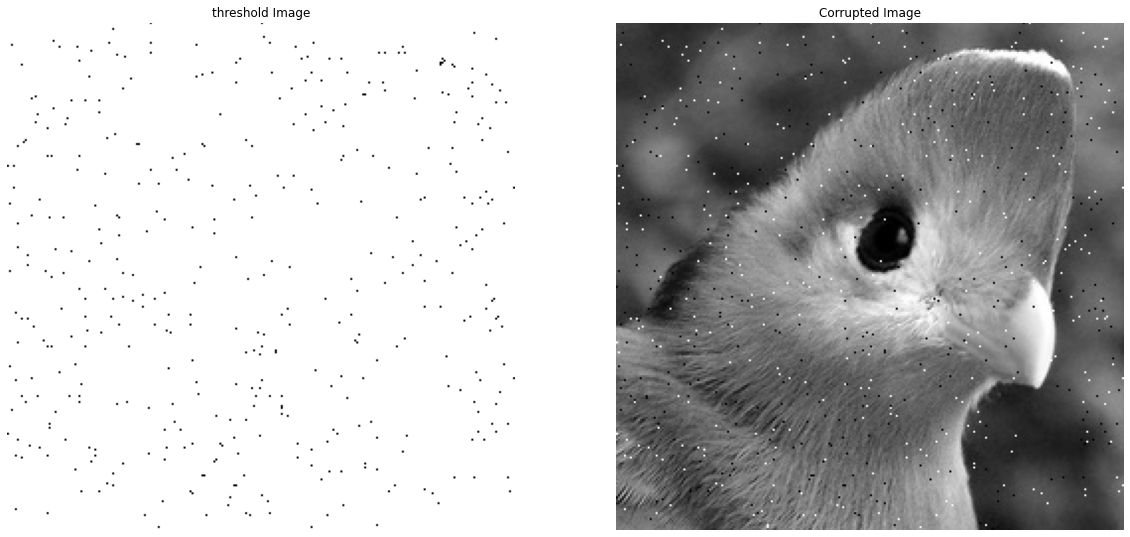

In [173]:

K, N = threshold(_Ucorr, thre=30)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(K * 255, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("threshold Image")
ax[0].axis('off')
ax[1].imshow(_corr_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')
            

In [187]:

def _denoise(img, lam=1, eps = 10):
    ''' OBJ = Fidelity term + Lambda * Total variation of gradient '''
    ''' Constraint: '''
    var = cp.Variable(img.shape)

    # threshold term
    known_mask, noise_mask = threshold(img, thre=30)

    # fidelity term
    fid = 0.5 * cp.sum_squares(var - img)

    # regularization term
    reg = cp.tv(var)

    # objective
    obj =  cp.Minimize(reg + lam * fid)
    # obj =  cp.Minimize(reg)
    constraints = [cp.abs(cp.multiply(known_mask, var) - cp.multiply(known_mask, img)) <= eps]
    # obj = cp.Minimize(cp.tv(var))
    # constraints = [cp.multiply(known_mask, var) == cp.multiply(known_mask, img)]
    prob = cp.Problem(obj, constraints = constraints)
    prob.solve(verbose = True, solver = 'SCS')

    return var.value


In [188]:
result = _denoise(Ucorr, lam=0.01)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 11 03:18:54 PM: Your problem has 65536 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 11 03:18:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 11 03:18:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 11 03:18:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 11 03:18:54 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 11 03:18:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

892973

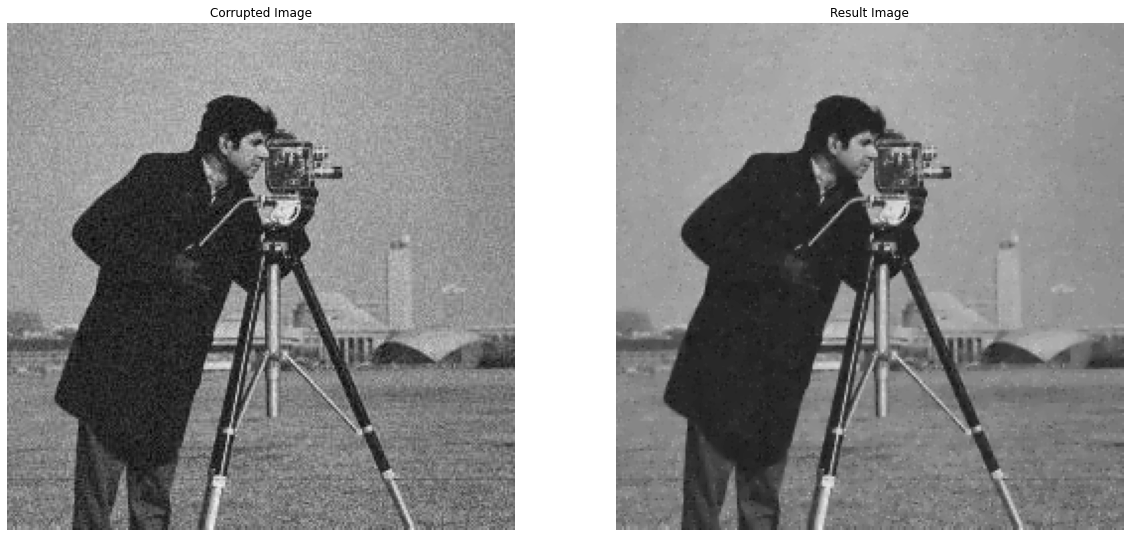

In [189]:
# Compare image.
fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(Ucorr, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Corrupted Image")
ax[0].axis('off')
ax[1].imshow(result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Result Image")
ax[1].axis('off')

np.sum(abs(result.astype(int) - Uorig.astype(int)))

In [190]:
_result = _denoise(_Ucorr, lam=0.01, eps=5)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 11 03:19:53 PM: Your problem has 65536 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 11 03:19:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 11 03:19:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 11 03:19:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 11 03:19:53 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 11 03:19:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

231088

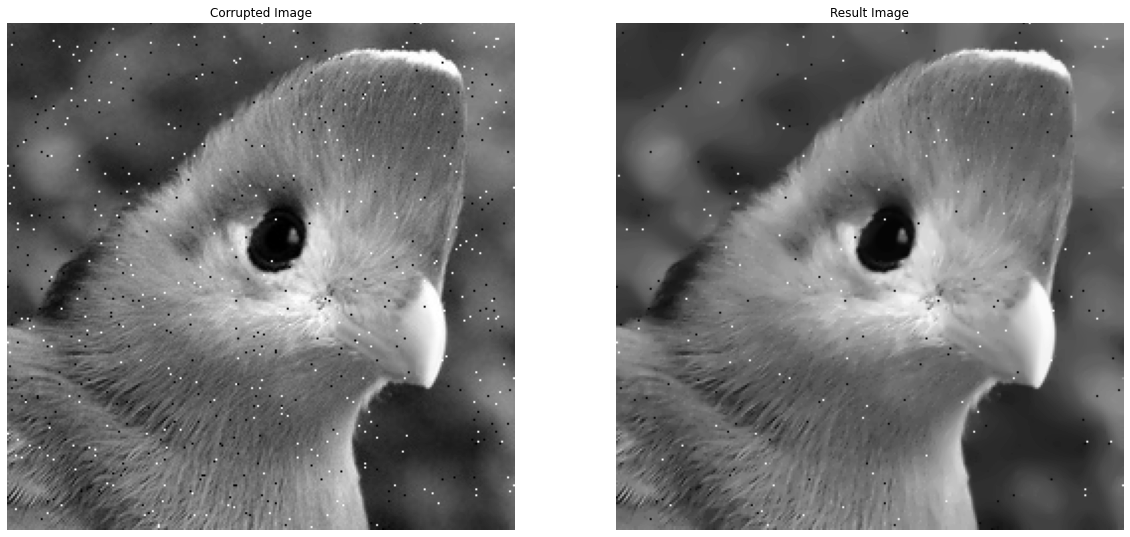

In [191]:
# Compare image.
fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(_Ucorr, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Corrupted Image")
ax[0].axis('off')
ax[1].imshow(_result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Result Image")
ax[1].axis('off')

np.sum(abs(_result.astype(int) - _Uorig.astype(int)))

In [110]:
def threshold_constraint(mask, img, thre=200):

    # known is 1 if the pixel is known,
    # 0 if the pixel was corrupted.
    constraint_list = []

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == 0:
                if i != 0:
                    # top
                    if thre < abs(int(img[i][j]) - int(img[i-1][j])):
                        constraint_list.append(thre >= cp.abs(int(img[i][j]) - int(img[i-1][j])))

                if i != img.shape[0] - 1:
                    # bottom
                    if thre < abs(int(img[i][j]) - int(img[i+1][j])):
                        constraint_list.append(thre >= cp.abs(int(img[i][j]) - int(img[i+1][j])))

                if j != 0:
                    # left
                    if thre < abs(int(img[i][j]) - int(img[i][j-1])):
                        constraint_list.append(thre >= cp.abs(int(img[i][j]) - int(img[i][j-1])))

                if j != img.shape[1] - 1:
                    # right
                    if thre < abs(int(img[i][j]) - int(img[i][j+1])):
                        constraint_list.append(thre >= cp.abs(int(img[i][j]) - int(img[i][j+1])))

    return constraint_list

def __denoise(img, lam=1):

    ''' OBJ = Fidelity term + Lambda * Total variation of gradient '''
    ''' Constraint: '''
    var = cp.Variable(img.shape)

    # threshold term
    known_mask,noise_mask = threshold(Ucorr, thre=100)
    pixel_constraints =threshold_constraint(known_mask, img, thre=100)

    # fidelity term
    fid = 0.5 * cp.sum_squares(var - img)

    # regularization term
    reg = cp.tv(var)

    # objective
    obj =  cp.Minimize(fid + lam * reg)
    prob = cp.Problem(obj, constraints = pixel_constraints)
    prob.solve(verbose = True)

    return var.value

result = __denoise(Ucorr, lam=5)

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 11 01:48:57 PM: Your problem has 65536 variables, 1153 constraints, and 0 parameters.
(CVXPY) Mar 11 01:48:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 11 01:48:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 11 01:48:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 11 01:48:57 PM: Compiling problem (target solver=ECOS).
(CVXPY) Mar 11 01:48:57 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuff

TypeError: Image data of dtype object cannot be converted to float

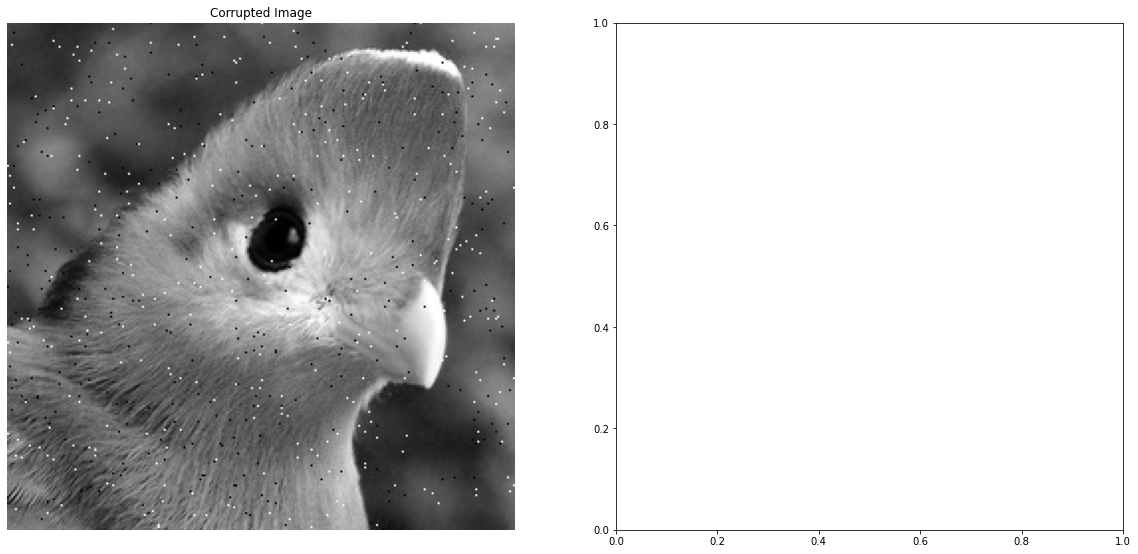

In [111]:
# Compare image.
fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(Ucorr, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Corrupted Image")
ax[0].axis('off')
ax[1].imshow(result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Result Image")
ax[1].axis('off')